# Sample code in Python for Tableau integration

## Circle packing

In [1]:
# pandas is the de facto standard library of python for data manipulation
# circlify: a circle packing library
import pandas as pd
import circlify as circ

# read gapminder csv and filter the population of each country year 2018
gapminder = (
    pd.read_csv("data/gapminder-data-with-continent.csv")
    .loc[lambda x: x.year == 2018][["country", "population"]]
)

# feed the population numbers to packcircles library to get the values for x and y axis
xy = pd.DataFrame(
    [(c.x, c.y, c.r) for c in circ.circlify(list(gapminder["population"]))],
    columns=["x", "y", "r"]
)

# bind country/population columns and x,y columns into the same data table 
gapminder_xy = pd.concat([gapminder.reset_index(drop=True), xy], axis=1) 

# plot to verify the bubble positions
# gapminder_xy["population2"] = gapminder_xy["population"] / 100000
# gapminder_xy.plot.scatter(x = "x", y = "y", s = "population2")

## UN votes dataset: dimension reduction

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

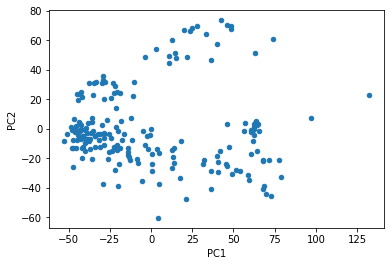

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# preprocess the data and encoding with numerical values
# so that it would be much easier to find correlations or clusters
# then we pivot the data from long table to wide table so that each country is an observation
unvotes = pd.read_csv("data/unvotes/unvotes.csv")
unvotes["voteval"] = 0
unvotes.loc[unvotes["vote"] == "yes", "voteval"] = 1
unvotes.loc[unvotes["vote"] == "no", 'voteval'] = -1

unvotes = unvotes.pivot_table(
    index=["country"],
    columns="rcid",
    values="voteval"
)
unvotes.fillna(0, inplace=True)

# normalize before applying PCA
x = StandardScaler().fit_transform(unvotes)
pca = PCA(n_components=2)
pca.fit(x)
pca_unvotes = pca.transform(x)

df = unvotes.reset_index()
df = pd.concat([
    df[["country"]],
    pd.DataFrame(data=pca_unvotes, columns=["PC1", "PC2"])
], axis=1)
df.plot.scatter(x = "PC1", y = "PC2")

## Build a logistic regression model for credit card default prediction

In [9]:
import pandas as pd
import numpy as np
import sklearn.linear_model as skl_lm

df = pd.read_csv("data/creditcard-default.csv")[["default", "student", "balance", "income"]]
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

,default,student,balance,income,default2,student2
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,0,1
2,No,No,1073.549164,31767.138947,0,0


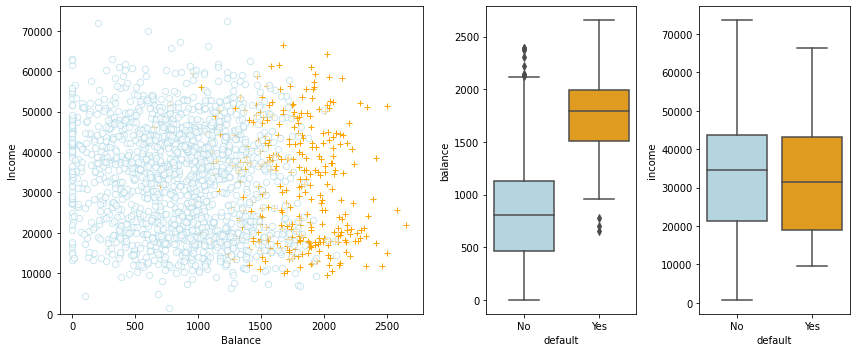

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths=1,
            edgecolors='lightblue', facecolors='white', alpha=.6)
ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot(x = 'default', y = 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot(x = 'default', y = 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

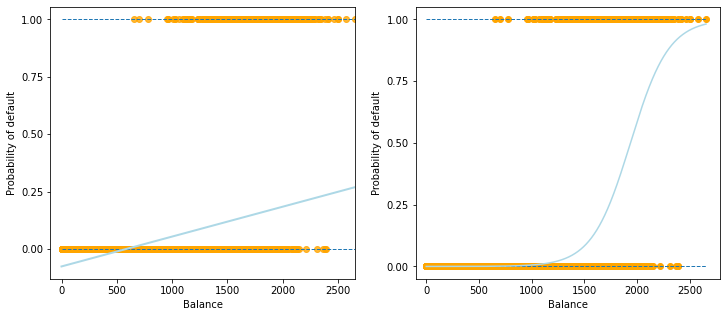

In [11]:
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(x = df.balance, y = df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

In [12]:
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
# I do not know the details on the differences between the solvers.
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(solver='newton-cg')
classes:  [0 1]
coefficients:  [[0.00549891]]
intercept : [-10.65132017]


In [37]:
# see: https://songhuiming.github.io/pages/2016/07/12/statsmodels-regression-examples/
import statsmodels.api as sm
import statsmodels.formula.api as smf

f = 'default2 ~ balance + income + student2'
X_train = sm.add_constant(df.balance)
logitfit = smf.logit(formula = str(f), data = df).fit()
logitfit.summary2()

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.462      
Dependent Variable: default2         AIC:              1579.5448  
Date:               2021-04-10 04:05 BIC:              1608.3862  
No. Observations:   10000            Log-Likelihood:   -785.77    
Df Model:           3                LL-Null:          -1460.3    
Df Residuals:       9996             LLR p-value:      3.2575e-292
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     10.0000                                       
-------------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|    [0.025    0.975]
-------------------------------------------------------------------
Intercept   -10.8690    0.4923  -22.0793  0.0000  -11.8339  -9.9042
balance       0.0057    0.0002   24.7365  0.0000    0.0053   0.0062
income        0.0000    0.0000    0.3698  0.7115   -0.0000   0.0000
student2     -0.6468    0.2363   -2.7376  0.0062   -1.1098  -0.1837
==================================================================

"""

In [73]:
def predict_default(_arg1, _arg2, _arg3):
    import pandas as pd
    df = pd.DataFrame(data={
        "balance": _arg1,
        "income": _arg2,
        "student": _arg3
    })
    df["student2"] = 1
    df.loc[df["student"] == "No", "student2"] = 0
    return list(logitfit.predict(df))

a = [496.42, 1346.14, 864.63, 1437.08, 493.44, 1715.85, 302.62, 1299.93, 415.92, 2012.51, 2097.48, 0.0, 304.11, 1611.5, 220.63, 0.0, 0.0, 548.59, 1328.25, 1562.3, 132.68, 1443.04, 0.0, 612.7, 0.0, 1000.29, 974.95, 696.18, 2696.76, 1364.03, 1286.51, 0.0, 784.13, 0.0, 0.0, 624.62, 1135.95, 1629.38, 791.59, 512.82, 74.54, 1721.81, 573.94, 1454.97, 1669.63, 1486.27, 1850.02, 1188.12, 0.0, 1344.65, 974.95, 314.55, 904.88, 1426.64, 0.0, 0.0, 564.99, 198.27, 496.42, 791.59, 940.66, 161.0, 0.0, 198.27, 0.0, 897.43, 2069.15, 1325.27, 1225.39, 1615.97, 532.2, 1644.29, 988.36, 895.94, 1408.75, 43.23, 793.08, 216.16, 582.88, 0.0, 241.5, 147.58, 749.84, 0.0, 0.0, 2652.04, 1214.96, 0.0, 863.14, 1753.12, 1525.03, 1210.49, 0.0, 1396.83, 0.0, 0.0, 2057.23, 231.07, 559.03, 1954.37, 444.24, 642.51, 2365.81, 1565.28, 1110.61, 313.06, 0.0, 0.0, 338.4, 442.75, 70.07, 0.0, 1559.32, 1144.89, 403.99, 760.28, 0.0, 1999.09, 0.0, 0.0, 0.0, 676.8, 1347.63, 0.0, 0.0, 0.0, 2093.01, 0.0, 1876.85, 380.14, 1293.97, 0.0, 1359.56, 1517.58, 1244.77, 11.93, 111.81, 278.77, 0.0, 2380.72, 2124.31, 901.9, 997.31, 1058.43, 101.37, 957.06, 1200.05, 0.0, 0.0, 0.0, 866.12, 796.06, 232.56, 0.0, 0.0, 0.0, 639.53, 1520.56, 973.46, 0.0, 1246.26, 0.0, 1618.95, 0.0, 816.93, 849.72, 0.0, 0.0, 0.0, 1638.33, 0.0, 421.88, 161.0, 1079.3, 2344.94, 0.0, 0.0, 572.45, 675.31, 1844.05, 630.59, 769.22, 1176.2, 0.0, 2158.6, 670.84, 280.26, 0.0, 1386.39, 187.83, 802.02, 2514.89, 500.89, 2125.8, 0.0, 1195.58, 1116.57, 102.86, 0.0, 851.22, 1235.83, 1562.3, 0.0, 2103.44, 679.78, 951.1, 0.0, 1812.75, 342.87, 1091.23, 141.62, 1191.11, 459.15, 949.6, 1015.2, 366.72, 77.52, 1423.66, 290.7, 973.46, 1857.47, 1833.62, 2309.16, 854.2, 1045.01, 1602.55, 1538.45, 718.54, 232.56, 1577.21, 985.38, 979.42, 1027.12, 0.0, 1981.2, 284.73, 728.97, 660.4, 77.52, 242.99, 220.63, 0.0, 23.85, 1276.08, 0.0, 0.0, 296.66, 0.0, 0.0, 146.09, 0.0, 196.78, 2019.96, 324.98, 1562.3, 175.91, 0.0, 0.0, 0.0, 1627.89, 514.31, 1565.28, 693.2, 198.27, 970.48, 818.42, 22.36, 1404.28, 0.0, 1150.86, 202.74, 649.96, 1085.26, 1870.89, 1441.55, 788.6, 311.57, 791.59, 372.69, 401.01, 806.49, 0.0, 1934.99, 1326.76, 0.0, 0.0, 0.0, 0.0, 1286.51, 723.01, 237.03, 460.64, 717.05, 2499.98, 0.0, 0.0, 436.79, 280.26, 0.0, 1059.92, 864.63, 256.41, 439.77, 617.17, 1349.12, 0.0, 104.35, 0.0, 1015.2, 1319.31, 1544.41, 1258.19, 1226.88, 1256.7, 1699.45, 690.22, 1702.43, 202.74, 0.0, 0.0, 7.45, 120.75, 395.05, 2980.0, 618.66, 1091.23, 2028.9, 1466.89, 180.38, 1261.17, 1571.25, 706.61, 566.48, 271.32, 885.5, 289.2, 1380.43, 0.0, 903.39, 1650.26, 477.04, 635.06, 304.11, 611.21, 943.64, 0.0, 1352.11, 1776.97, 0.0, 749.84, 0.0, 450.21, 869.1, 633.57, 615.68, 2094.5, 1434.1, 0.0, 517.29, 910.85, 1061.41, 569.46, 1058.43, 861.65, 1853.0, 1177.69, 1884.3, 322.0, 514.31, 1800.82, 1478.82, 0.0, 1252.23, 1495.22, 876.56, 1490.75, 1143.4, 0.0, 1068.86, 0.0, 985.38, 1265.64, 2015.49, 569.46, 0.0, 1349.12, 553.07, 0.0, 1683.05, 1201.54, 2076.61, 1074.83, 0.0, 0.0, 1094.21, 834.82, 715.56, 205.72, 0.0, 1440.06]
b = [5435.215, 38699.125, 38176.445, 54357.26, 20396.93, 29265.7, 7663.54, 26063.920000000002, 5520.625, 25937.265000000003, 23029.675, 5491.425, 29424.84, 15943.93, 6987.5599999999995, 7332.485, 19563.27, 13321.04, 18093.05, 15358.835000000001, 6460.5, 13632.02, 7337.595, 23369.855, 3920.8300000000004, 5142.85, 15501.914999999999, 11969.445, 68121.40999999999, 9786.744999999999, 12461.830000000002, 10563.465, 48976.065, 11448.955, 7354.749999999999, 8522.75, 22780.745, 10952.555, 4305.175, 4981.155, 12756.750000000002, 41485.535, 16117.67, 13479.085000000001, 11629.265, 28243.699999999997, 7128.815, 16295.79, 16250.529999999999, 15869.835, 13272.130000000001, 14492.324999999999, 16134.824999999999, 5950.959999999999, 5596.545, 12014.339999999998, 20841.5, 27839.644999999997, 3779.2099999999996, 18933.28, 12961.15, 7751.87, 11198.93, 5158.18, 11739.86, 4380.0, 41547.585, 4083.2549999999997, 10164.155, 18068.23, 9084.485, 21455.065, 8372.735, 8755.985, 5877.595, 12051.205000000002, 11177.03, 7641.64, 40503.32, 5604.21, 9989.685, 19520.199999999997, 8640.28, 7017.125000000001, 15892.1, 55588.770000000004, 20208.954999999998, 4285.465, 5679.400000000001, 21728.45, 7369.714999999999, 17701.77, 11217.545, 6014.835, 13873.285, 5140.66, 5223.88, 9514.455, 13247.675000000001, 30605.614999999998, 7720.844999999999, 6561.24, 25080.245, 53356.795, 5783.79, 4391.3150000000005, 6138.9349999999995, 14275.15, 39414.89, 4949.765, 12606.005, 10429.875, 16792.555, 25276.615, 6015.929999999999, 14761.33, 12839.605, 33347.13, 9869.235, 8399.380000000001, 9942.965, 54049.200000000004, 22849.73, 4309.92, 10790.86, 10065.97, 9645.855, 20878.73, 45004.135, 6622.925, 8684.445, 3914.9900000000002, 8498.295, 7831.075, 12652.36, 16232.645, 19951.995, 13269.574999999999, 7801.509999999999, 39361.965, 14538.315, 33534.740000000005, 37920.945, 7167.139999999999, 6348.08, 7128.085, 6225.075, 8707.805, 5542.16, 4907.06, 23334.815, 13090.359999999999, 15117.935, 33620.88, 20095.44, 7131.004999999999, 11611.015, 20533.44, 15460.305, 19461.435, 4466.87, 11443.845000000001, 23290.285, 4991.74, 28025.43, 9264.795, 13027.215, 10732.095, 10026.55, 9975.449999999999, 12691.779999999999, 13480.91, 27867.02, 5433.755, 44469.41, 10998.18, 8778.25, 8168.335, 10335.34, 21179.49, 3881.775, 16827.23, 21509.085, 29514.265000000003, 57994.485, 11103.300000000001, 13312.28, 8528.224999999999, 30612.185, 21298.114999999998, 20143.254999999997, 45365.850000000006, 10405.42, 47526.285, 11098.189999999999, 8717.295, 33959.235, 18505.135, 9982.385, 3797.0950000000003, 8741.385, 26978.61, 7678.87, 24895.190000000002, 20928.005, 3939.4449999999997, 8559.25, 3957.3300000000004, 18740.925, 55460.655, 8958.195, 10791.955, 14287.925000000001, 14389.029999999999, 12741.785, 14974.125, 5648.740000000001, 4546.44, 3878.855, 14218.210000000001, 16369.155, 35957.975, 12204.505, 10041.880000000001, 44423.785, 5503.835, 21855.835, 24450.985, 25245.225000000002, 25529.195, 12123.109999999999, 9170.26, 5745.465, 4235.095, 25424.440000000002, 3833.5950000000003, 15523.085000000001, 22111.335, 9684.18, 10202.480000000001, 10842.324999999999, 5694.7300000000005, 7635.07, 21230.225, 8234.765, 12595.785, 7149.620000000001, 13272.859999999999, 5736.705, 8239.51, 3782.495, 10393.01, 26624.925, 31180.125, 13325.42, 21192.995000000003, 9466.64, 5704.585, 15111.0, 12284.804999999998, 24797.004999999997, 65838.33499999999, 3864.62, 10849.625, 10219.635, 14923.025, 32422.95, 10817.87, 9485.619999999999, 14255.075, 5791.09, 16416.97, 11100.745, 6114.115000000001, 11150.75, 59615.08500000001, 8433.69, 15159.179999999998, 46734.6, 19826.435, 19491.365, 13191.830000000002, 23189.91, 18223.355, 5369.515, 6922.955, 6583.14, 22063.885, 6099.514999999999, 3960.98, 9625.050000000001, 8792.12, 18809.18, 51345.28, 15663.975, 9954.279999999999, 24052.04, 20094.71, 7588.715, 9095.435, 7951.89, 11437.275, 21847.074999999997, 16082.265, 30187.690000000002, 8927.9, 16468.8, 27523.190000000002, 5458.94, 27468.805, 12298.310000000001, 8531.875, 10156.125, 33720.89, 42164.799999999996, 5284.835, 19045.335, 24988.63, 6917.115, 10070.35, 5941.835, 9153.47, 9938.585, 66695.72, 11325.585, 6484.225, 45800.200000000004, 17945.59, 15035.08, 34380.445, 7447.825000000001, 4592.065, 22749.72, 7669.014999999999, 8843.95, 8874.61, 11992.44, 4531.11, 15098.225, 54500.340000000004, 10144.81, 4830.41, 5327.175, 3918.2749999999996, 17599.57, 10954.380000000001, 7866.115, 58484.314999999995, 4903.045, 17730.605, 10950.73, 22491.3, 38136.295, 15281.820000000002, 4404.82, 65948.93, 12585.199999999999, 14457.285, 10990.515, 4502.275000000001, 19551.59, 19424.204999999998, 9549.13, 23423.145, 46964.185000000005, 41526.78, 22290.185, 8684.445, 32485.0, 26163.93, 12997.65, 14277.34, 7220.43, 20225.38, 10731.0, 7655.51, 31983.125, 10272.56, 7062.385, 19457.42, 42019.895000000004, 37152.619999999995, 9060.76, 5216.58, 7332.120000000001, 9636.0, 7027.345, 6033.085, 13825.47, 30641.019999999997, 49318.07, 26764.355, 9480.51, 6320.339999999999, 18174.809999999998, 4415.04, 4877.860000000001, 21123.28, 13770.720000000001, 6825.865]
c = ['No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No']
predict_default(a, b, c)

[0.00033373089220830525,
 0.024691616055839652,
 0.0030386934480123437,
 0.07868581691581675,
 0.00034330395139225495,
 0.28144876016300135,
 0.00011056272049835671,
 0.034458734931142085,
 0.00021038280473887645,
 0.5268822007630738,
 0.7743465719218983,
 1.9357964771610733e-05,
 0.00011912026567057556,
 0.17131986656042372,
 6.89400974237394e-05,
 1.9466374765946486e-05,
 2.020215630687877e-05,
 0.0004610019952473506,
 0.039367635769608646,
 0.1346665995141652,
 4.15601139233141e-05,
 0.07244754258715183,
 1.946667650932585e-05,
 0.0006863768346246124,
 1.9265958327140882e-05,
 0.00596848502110644,
 0.0027981605924204825,
 0.0010699249638832806,
 0.9918985327329297,
 0.04677097697764289,
 0.030733942412625153,
 1.9658099291776485e-05,
 0.001980718599117479,
 1.9710972649407982e-05,
 1.9467689539164697e-05,
 0.0003680838043813531,
 0.013605828143552831,
 0.1840907589391731,
 0.0018056533944328474,
 0.0003661356371939421,
 3.0348013553182934e-05,
 0.18052352520212164,
 0.00053766168237

In [75]:
from tabpy.tabpy_tools.client import Client
client = Client('http://localhost:9004/')
client.deploy("predict_default", predict_default, "A predictor to predict credit card default.", override=True)